# Client Segmentation 

    In this notebook, we will use some client data to create a KMeans model to perform customer segmentation. That is, we will try to divide them into groups of individuals based on similarities, such as Age, Gender, Income, and Spending Score (a score based on customer behavior and spending nature).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading dataset 

In [2]:
df = pd.read_csv("Mall_Customers.csv")

In [3]:
df.shape

(200, 5)

In [4]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [6]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [7]:
df = df.drop(columns="CustomerID")

In [8]:
df.isna().any(1).sum()

0

# Exploratory Analysis 

In [9]:
income_col = "Annual Income (k$)"
spending_col = "Spending Score (1-100)"
gender_col = "Gender"
age_col = "Age"
gender_cat_col = "Gender_category"

Text(0, 0.5, 'Count')

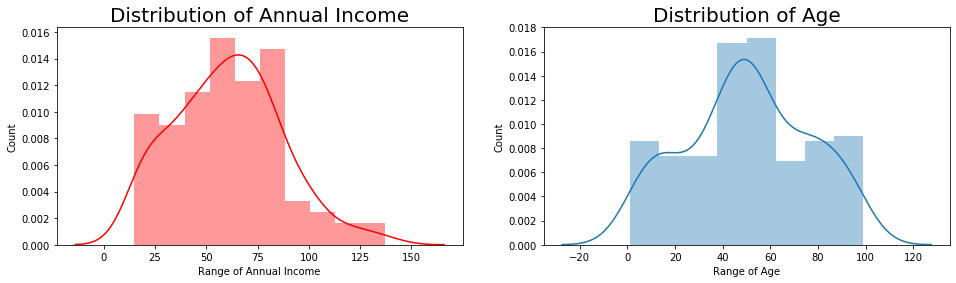

In [10]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
sns.distplot(df[income_col], color="red")
plt.title('Distribution of Annual Income', fontsize = 20)
plt.xlabel('Range of Annual Income')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.distplot(df[spending_col])
plt.title('Distribution of Age', fontsize = 20)
plt.xlabel('Range of Age')
plt.ylabel('Count')

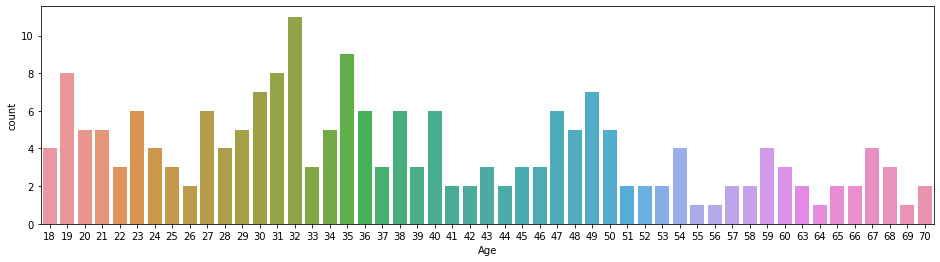

In [11]:
plt.figure(figsize=(16, 4))

sns.countplot(x=age_col, data=df)

<Figure size 1152x576 with 0 Axes>

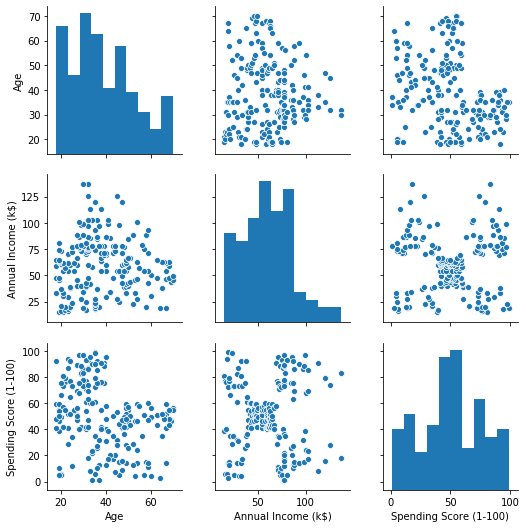

In [12]:
plt.figure(figsize=(16, 8))
sns.pairplot(df)

Text(0, 0.5, 'Spending Score (1-100)')

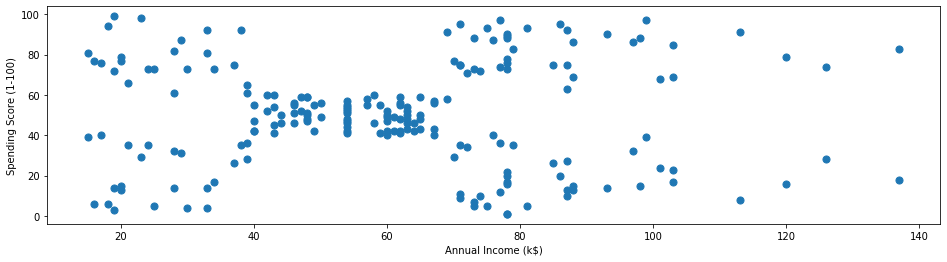

In [13]:
plt.figure(figsize=(16,4))
plt.scatter(x=df[income_col], y=df[spending_col], s=50)
plt.xlabel(income_col)
plt.ylabel(spending_col)

    By plotting Income vs. Spending score, we can identify what it seems to be five clusters.

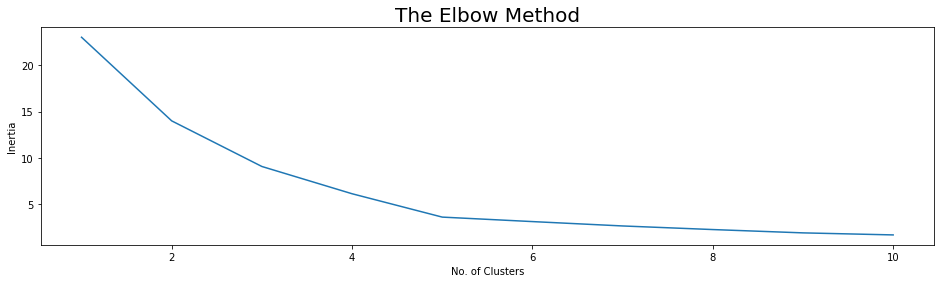

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

scaler = MinMaxScaler()
temp = df[[spending_col, income_col]]

X = pd.DataFrame(scaler.fit_transform(temp), columns=temp.columns)

inertias = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=20, random_state=101)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(16, 4))
plt.plot(range(1, 11), inertias)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.show()


    Indeed, by employing the Elbow Method, we can observe that Inertia flattens as the number of clusters reaches five.

In [15]:
km = KMeans(n_clusters=5, init='k-means++', max_iter=100, n_init=20, random_state=101)
df["cluster_1"] = km.fit_predict(X)

In [16]:
def convert_cluster_centers_coordinates(cluster_centers, df, columns, scaler="standard"):
    cc = pd.DataFrame(cluster_centers, columns=columns).to_dict("records")
    params = df[columns].describe().to_dict()

    for i in range(len(cc)):
        aux = []
        for key in cc[i]:
            if scaler == "standard":
                adder = params[key]["mean"]
                multiplier = params[key]["std"]
            elif scaler == "minmax":
                adder = params[key]["min"]
                multiplier = params[key]["max"] - params[key]["min"] 
            cc[i][key] = cc[i][key]*multiplier+adder

    return pd.DataFrame(cc)

In [17]:
centers = convert_cluster_centers_coordinates(km.cluster_centers_, df, X.columns.to_list(), scaler="minmax")

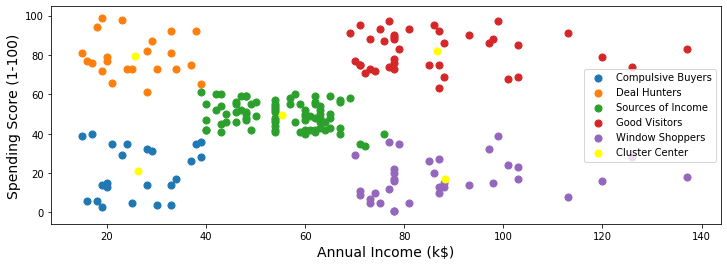

In [18]:
plt.figure(figsize=(12, 4))
labels = {0: "Deal Hunters", 1: "Sources of Income", 2: "Good Visitors", 3: "Compulsive Buyers", 4: "Window Shoppers"}

for i in df["cluster_1"].unique():
    aux = df[df["cluster_1"]==i]
    plt.scatter(aux[income_col], aux[spending_col], s=50, label=labels[i])

plt.scatter(centers[income_col], centers[spending_col], s=50, label="Cluster Center", color="yellow")
plt.xlabel(income_col, fontsize=14)
plt.ylabel(spending_col, fontsize=14)
plt.legend()

    As we expected, KMeans converged to the configuration we had anticipated. We have then these five clusters, which I've named:
        - Window Shoppers: they have low incomes and low spending scores;
        - Compulsive Buyers: they have high spending scores, despite having low incomes;
        - Deal Hunters: they lie in the middle of both dimensions;
        - Good Visitors: they have high incomes, however low spending scores;
        - Sources of Income: they have high incomes and high spending scores.

# Modeling 

    Now we'll use all available data to perform the clustering.

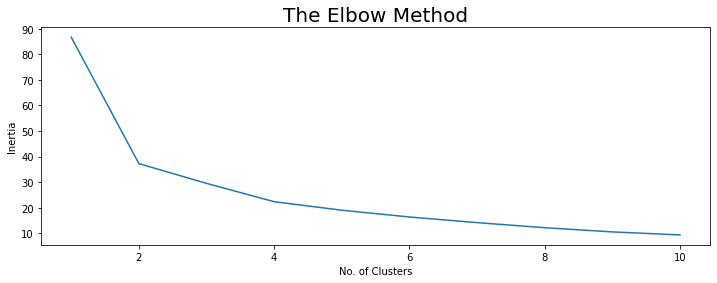

In [19]:
df[gender_cat_col] = df[gender_col].factorize()[0]

scaler = MinMaxScaler()

temp = df[[gender_cat_col, spending_col, income_col, age_col]]

X = pd.DataFrame(scaler.fit_transform(temp), columns=temp.columns)

inertias = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=20, random_state=101)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(12, 4))
plt.plot(range(1, 11), inertias)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.show()

    The Elbow Method is quite subjective, but four seems to be a reasonable number of clusters.

In [20]:
n_cluster = 4
km = KMeans(n_clusters=n_cluster, init='k-means++', max_iter=100, n_init=20, random_state=101)
df["cluster_2"] = km.fit_predict(X)

# Evaluating 

    Since we used four dimensions to perform the clustering, we can't plot all of them in a single chart to visualize the ensemble. So we'll start the evaluation by superficially boxplotting each variable for each cluster.

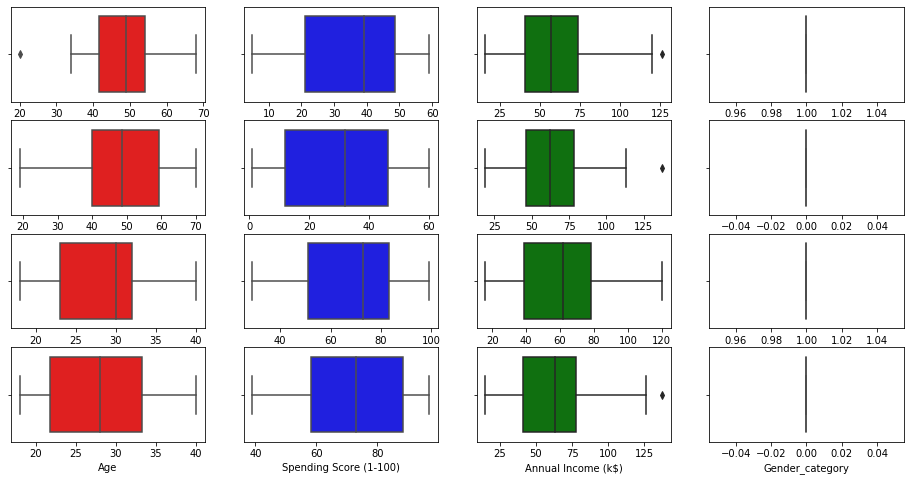

In [21]:
f, axes = plt.subplots(n_cluster, 4, sharey=True)
f.set_figheight(8)
f.set_figwidth(16)

dict_color = {age_col: "red", spending_col: "blue", income_col: "green", gender_cat_col: "orange"}

row = 0
for i in range(n_cluster):
    aux = df[df["cluster_2"] == i]
    column = 0
    for col in [age_col, spending_col, income_col, gender_cat_col]:
        sns.boxplot(aux[col], ax=axes[row, column], color=dict_color[col])
        column += 1
    row += 1


    At first glance, these plots don't tell much. Sure: Age, Spending Score, and Income vary slightly among clusters, but there doesn't seem to be evident patterns in each one of them. However, one interesting thing happened with Gender: every segment contains either only men or only women.

    To have a better understanding of what is happening, we will plot three variables at a time.

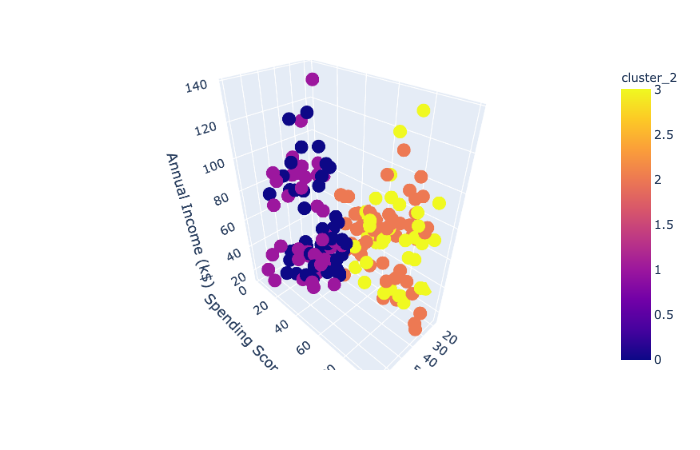

In [24]:
import plotly.express as px

fig = px.scatter_3d(df, x="Age", y=spending_col, z=income_col,
              color='cluster_2')

fig.show("png")

    By plotting Age, Income, and Spending Score, we observe a lot of overlapping between clusters - especially between the blue and purple ones and the orange and yellow ones.

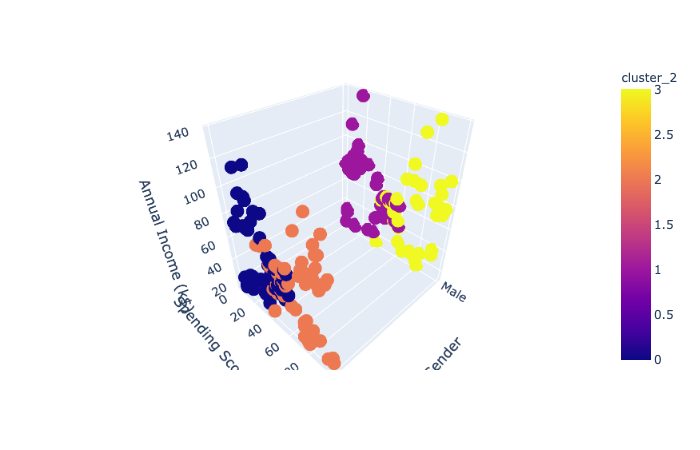

In [25]:
import plotly.express as px

fig = px.scatter_3d(df, x=gender_col, y=spending_col, z=income_col,
              color='cluster_2')

fig.show("png")

    When we include Gender in the visualization, we conclude that Income and Spending Score share the same pattern regardless of Gender - that's why these clusters had such an intersection in the previous plot.

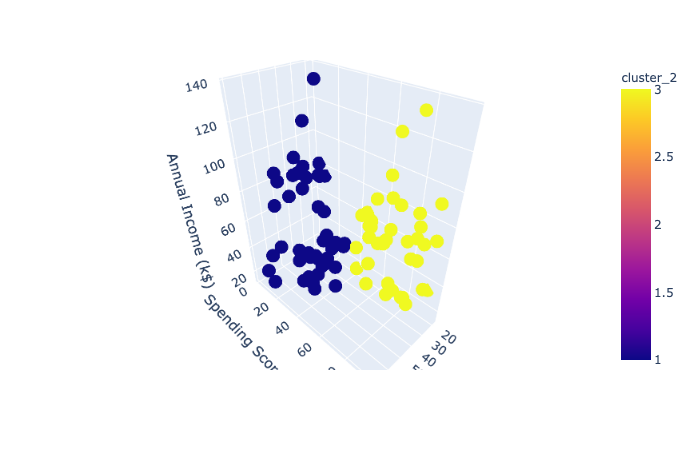

In [26]:
male = df[df[gender_col] == "Male"]

fig = px.scatter_3d(male, x=age_col, y=spending_col, z=income_col,
              color='cluster_2')

fig.show("png")

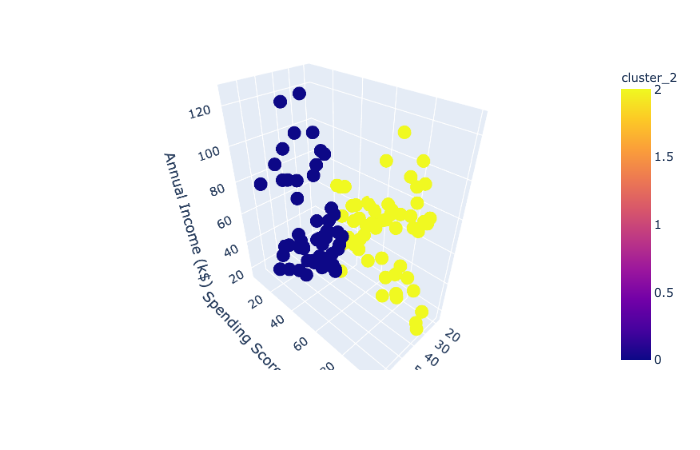

In [27]:
female = df[df[gender_col] == "Female"]

fig = px.scatter_3d(female, x=age_col, y=spending_col, z=income_col,
              color='cluster_2')

fig.show("png")

    By plotting Age, Income, and Spending Score separately for men and women, we can confirm that Gender is irrelevant to the segmentation. Since the variable has no role, we will redo the modeling without it.

# Remodeling

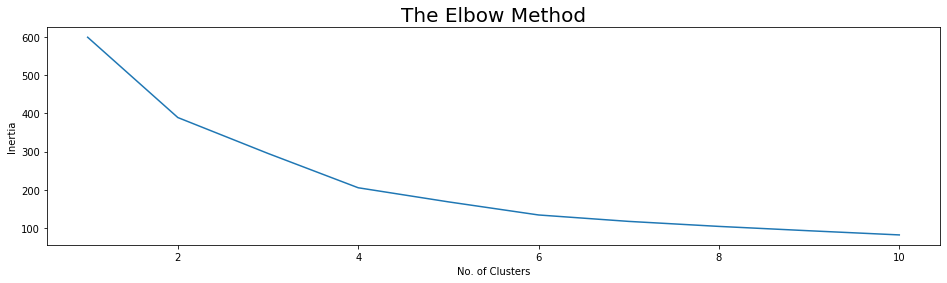

In [28]:
scaler = StandardScaler()

temp = df[[spending_col, income_col, age_col]]

X = pd.DataFrame(scaler.fit_transform(temp), columns=temp.columns)

inertias = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=20, random_state=101)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(16, 4))
plt.plot(range(1, 11), inertias)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.show()

    Again, four seems the optimal number of clusters. There is also a break at six, though it is softer.

In [30]:
def get_cluster_label_for_four(cluster):
    if cluster == 0:
        return "Compulsive Buyers/Deal Hunters"
    elif cluster == 1:
        return "Window Shoppers/Deal Hunters"
    elif cluster == 2:
        return "Good Visitors"
    elif cluster == 3:
        return "Income Sources"

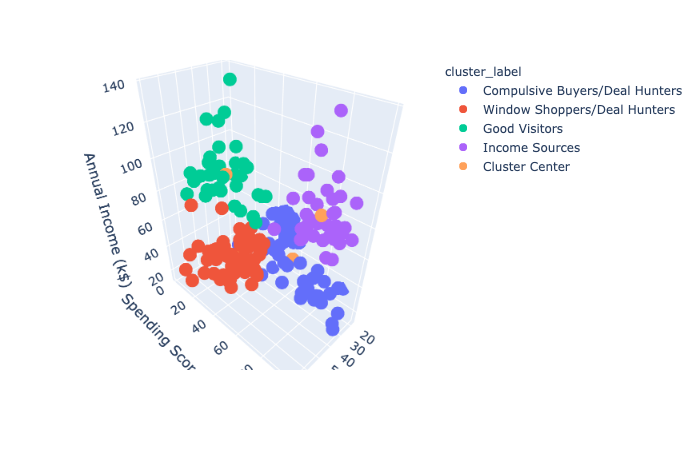

In [31]:
km = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=20, random_state=101)
df["cluster_3"] = km.fit_predict(X)
df["cluster_label"] = df["cluster_3"].apply(get_cluster_label_for_four)
centers = convert_cluster_centers_coordinates(km.cluster_centers_, df, X.columns.to_list(), scaler="standard")
centers["cluster_label"] = "Cluster Center"


four_clusters = df[X.columns.to_list()+["cluster_label"]].append(centers)
fig = px.scatter_3d(four_clusters, x=age_col, y=spending_col, z=income_col, color="cluster_label")

fig.show("png")

    Results aren't bad, but they could be much better. The green and purple clusters seem right, as they are isolated. However, the red and blue ones aggregate different patterns within them. The red one contains what we had previously named Window Shoppers plus part of the Deal Hunters. The blue cluster contains the Compulsive Buyers and the remainder of the Deal Hunters.

    So we'll redo once again the modeling, this time employing six as the number of clusters.

# Remodeling - Six Clusters 

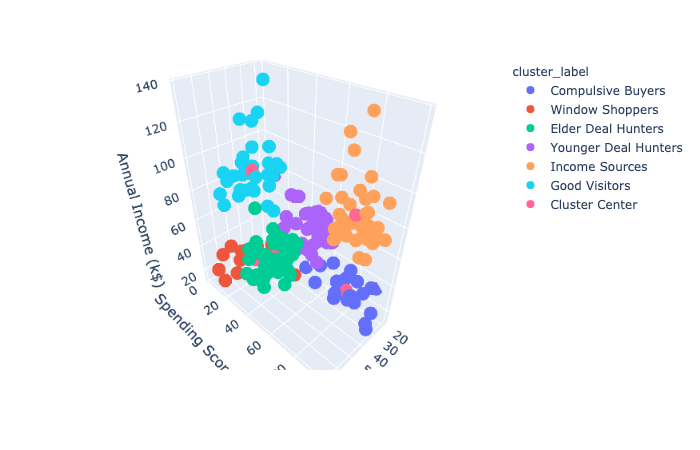

In [32]:
def get_cluster_label_for_six(cluster):
    if cluster == 0:
        return "Window Shoppers"
    elif cluster == 1:
        return "Income Sources"
    elif cluster == 2:
        return "Younger Deal Hunters"
    elif cluster == 3:
        return "Elder Deal Hunters"
    elif cluster == 4:
        return "Good Visitors"
    elif cluster == 5:
        return "Compulsive Buyers"

km = KMeans(n_clusters=6, init='k-means++', max_iter=100, n_init=20, random_state=101)
df["cluster_3"] = km.fit_predict(X)
df["cluster_label"] = df["cluster_3"].apply(get_cluster_label_for_six)
centers = convert_cluster_centers_coordinates(km.cluster_centers_, df, X.columns.to_list(), scaler="standard")
centers["cluster_label"] = "Cluster Center"


six_clusters = df[X.columns.to_list()+["cluster_label"]].append(centers)
fig = px.scatter_3d(six_clusters, x=age_col, y=spending_col, z=income_col, color="cluster_label")

fig.show("png")

# Conclusion 

    In this project, we:

        1) had fun;

        2) were able to create a superb customer segmentation model based on Income, Age, and Spending Score. We ended up with clusters that can intuitively illustrate and highlight customers' traces in each segment.

    It is worth noting that the analysis was simple to perform because it was a small dataset. With only 200 records, we were able to compute results in a short time. Also, since we had several features, we were able to visualize the data with plots and identify patterns.